In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

# Creating the investment analysis crew

## Planner and Replanner

In [4]:
from typing import TypedDict, List, Literal, Optional
from pydantic import BaseModel, Field

import sys
sys.path.append("../tools")

from technical_analysis_tools import technical_analysis
from fundamental_analysis_tools import evaluate_fundamentals

In [5]:
from typing import Union

class UseAgent(BaseModel):
    agent_to_use: Literal[ "technical_analysis_agent", "fundamental_analysis_agent"] = Field(..., description="Agent to use")
    query_to_send: str = Field(..., description="The query to ask this agent")

class Step(BaseModel):
    step_number: int = Field(..., description="The step number in the plan")
    action: UseAgent = Field(
        ..., 
        description= (
            "Action to perform. Use `Respond` if you want to respond to the user "
            "without using a tool. If you need tools, use `UseAgent`. "
        )
    )

class Plan(BaseModel):
    steps: List[Step] = Field(..., description="The list of steps in the plan")

### Planner

In [6]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_template(
    """For a given objective, come up with a simple step by step plan to
    acquire the information required to achieve the objective.
    
    The plan should involve individual tasks only.
    
    <important>
        Invoke the fundamental_analysis_agent and technical_analysis_agent only once per company of interest.
        If there are two companies of interest, invoke the respective agent/s twice.
        Always use both agents to analyze stock market data when evaluating investments.
    </important>
    
    The user's question is: {objective}
    """
)

llm_planner = planner_prompt | llm.with_structured_output(Plan)
query = "Based on the past year of stock market data, recommend whether to buy, hold, or sell the stocks of Apple and Tesla."

In [ ]:
plan = llm_planner.invoke(query)

In [29]:
for step in plan.steps:
    print(step)

step_number=1 action=UseAgent(agent_to_use='fundamental_analysis_agent', query_to_send='Analyze Apple Inc. (AAPL) using financial data from the past 12 months. Provide a concise fundamental assessment including: revenue growth, gross margin, operating margin, net income, free cash flow, balance sheet strength (debt vs cash), capital allocation (buybacks, dividends), product/service revenue mix and growth, R&D investment, competitive positioning, regulatory/regulatory risks, and key catalysts. Include data sources and a brief quantitative summary.')
step_number=2 action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Analyze Apple Inc. (AAPL) using stock price data from the past 12 months. Compute and report: 50-day and 200-day moving averages, MACD, RSI, Bollinger bands, average true range, volatility, trend direction, and a buy/hold/sell signal based on standard technical indicators. Highlight support/resistance levels.')
step_number=3 action=UseAgent(agent_to_use='fu

### Replanner

In [7]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will acquire the required information to address the objective. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

This is the user's feedback:
{user_feedback}

Your task is to consider the user's feedback and refine the plan."""
)

llm_replanner = replanner_prompt | llm.with_structured_output(Plan)

In [ ]:
replan = llm_replanner.invoke(
    {
        "input": query,
        "plan": plan.model_dump_json(),
        "user_feedback": "Can you also include GOOG?"
    }
)

In [32]:
for step in replan.steps:
    print(step)

step_number=1 action=UseAgent(agent_to_use='fundamental_analysis_agent', query_to_send='Analyze Apple Inc. (AAPL) using financial data from the past 12 months. Provide a concise fundamental assessment including: revenue growth, gross margin, operating margin, net income, free cash flow, balance sheet strength (debt vs cash), capital allocation (buybacks, dividends), product/service revenue mix and growth, R&D investment, competitive positioning, regulatory/regulatory risks, and key catalysts. Include data sources and a brief quantitative summary.')
step_number=2 action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Analyze Apple Inc. (AAPL) using stock price data from the past 12 months. Compute and report: 50-day and 200-day moving averages, MACD, RSI, Bollinger bands, average true range, volatility, trend direction, and a buy/hold/sell signal based on standard technical indicators. Highlight support/resistance levels.')
step_number=3 action=UseAgent(agent_to_use='fu

## The Multi-Agent System

In [9]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Defining the graph's state

In [12]:
import time
import operator
from datetime import datetime
from uuid import uuid4
from typing import Annotated

from langchain.messages import AIMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Send, Command
from langgraph.graph import StateGraph, START, END, MessagesState

checkpointer = InMemorySaver()

class ToolCall(TypedDict):
    tool_name: str
    time_start: str
    time_end: str
    tool_result: str

class State(MessagesState):
    tool_calls: Annotated[List[ToolCall], operator.add]

Defining the graph's utility functions

In [10]:
class IsApproved(BaseModel):
    approved: Literal["yes", "no"] = Field(..., description="Whether the response is approved or not")
    feedback: Optional[str] = Field(None, description="Feedback from the user. Leave this as none if approved is a 'yes'.")

In [26]:
from typing import Tuple

def get_datetime() -> str:    
    return datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d %H:%M:%S")

def get_feedback(to_approve: Plan) -> Tuple[IsApproved, str]:
    """Function to handle feedback solicitation and feedback"""
    get_approval = interrupt({
        "question": "Approve execution?",
        "details": to_approve.steps
    })
    logger.info(f"User feedback: {get_approval}")
    parse_approval = llm.with_structured_output(
        IsApproved,
        method="function_calling"
    ).invoke(get_approval)
    return parse_approval

def execute_plan(
    plan: Plan, state: State
) -> Command[Literal["fundamental_analysis_agent", "technical_analysis_agent", "respond"]]:    
    """This function routes plan steps to the respective nodes"""
    
    gotos = []
    if len(plan.steps) > 1:        
        for step in plan.steps:
            if isinstance(step.action, UseAgent):
                gotos.append(
                    Send(
                        step.action.agent_to_use,
                        {'query': step.action.query_to_send}
                    )
                )
    else:
        gotos.append(Send("respond", {"messages": state['messages']}))
    
    return Command(goto=gotos)

def rewrite_original_query(query: str, feedback: List[str]):
    """Rewrites the original human query based on feedback received so that 
    the plan addresses the original question with the new feedback"""    
    rewrite = llm.invoke(
        f"""
        This is the original query: {query}
        
        We received the following user feedbacks: {feedback}
        
        Rewrite the original query to incorporate the feedbacks. Make it sound like
        a query from the user.
        
        <important>
            If there is no need to rewrite the query based on the feedback(because
            it does not add to the original query), just return the original query as is.
        </important>
        """
    )
    return rewrite.content

The nodes of the graph

In [27]:
from langchain.agents import create_agent

def router(state: State) -> Command[
    Literal["fundamental_analysis_agent", "technical_analysis_agent", "respond", "cancel"]
]:
    
    ### Initialization
    count_of_runs = 1
    feedbacks = []
    
    # Get plan
    query = state['messages'][-1].content
    response = llm_planner.invoke(query)
    
    # Seek feedback and replan in a loop
    while True:        
        
        # Get approval
        approval = get_feedback(response)
        
        if approval.approved == "yes":
            logger.info("Plan approved. Proceeding to execution.")
            if count_of_runs != 1:
                rewrite = rewrite_original_query(query, feedbacks)
                state['messages'][-1] = HumanMessage(content=rewrite)
            return execute_plan(response, state)
        
        else:
            
            ## IF the user rejects the plan but does not provide a meaningful feedback
            ## we route to the 'cancel' node.
            if not approval.feedback:
                return Command(
                    goto=Send(
                        "cancel",
                        {"message": "Cancelled due to a lack of feedback"}
                    )
                )
            
            feedbacks.append(approval.feedback)
            
            ## If the number of replan cycle reaches 3, break the loop. It's clear that
            ## the user needs to think further of their queries.
            if count_of_runs == 3:
                return Command(
                    goto=Send(
                        "cancel",
                        {"message": "Cancelled due to too many replaning iterations. Consider refining your query and try again."}
                    )
                )
            
            ## Replan
            response = llm_replanner.invoke(
                {
                    "input": query,
                    "plan": response.model_dump_json(),
                    "user_feedback": approval.feedback
                }
            )
            count_of_runs += 1


def technical_analysis_agent(state: State) -> Command[Literal["respond"]]:    
    logger.info(f"query: {state['query']}")
    start_time = get_datetime()
    ta_agent = create_agent(model=llm, tools=[technical_analysis])
    response = ta_agent.invoke({'messages': [HumanMessage(content=state['query'])]})    
    end_time = get_datetime()
    return Command(
        goto = "respond",
        update = {
            "messages": [AIMessage(content=response['messages'][-1].content, tool_call_id=uuid4().hex)],
            "tool_calls": [
                ToolCall(
                    time_start = start_time,
                    time_end = end_time,
                    tool_result = response,
                    tool_name = "technical_analysis"
                )
            ]
        }        
    )

def fundamental_analysis_agent(state: State) -> Command[Literal["respond"]]:
    start_time = get_datetime()
    fa_agent = create_agent(model=llm, tools=[evaluate_fundamentals])
    response = fa_agent.invoke({'messages': [HumanMessage(content=state['query'])]})
    end_time = get_datetime()
    return Command(
        goto = "respond",
        update = {
            "messages": [AIMessage(content=response['messages'][-1].content, tool_call_id=uuid4().hex)],
            "tool_calls": [
                ToolCall(
                    time_start = start_time,
                    time_end = end_time,
                    tool_result = response,
                    tool_name = "fundamental_analysis"
                )
            ]
        } 
    )

def respond(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

def cancel(state: State):
    return {'messages': [AIMessage(content=state.get("message", "Cancelled."))]}

In [28]:
graph = StateGraph(State)

graph.add_node("router", router)
graph.add_node("technical_analysis_agent", technical_analysis_agent)
graph.add_node("fundamental_analysis_agent", fundamental_analysis_agent)
graph.add_node("respond", respond)
graph.add_node("cancel", cancel)

graph.add_edge(START, "router")
graph.add_edge("respond", END)
graph.add_edge("cancel", END)

agent = graph.compile(checkpointer=checkpointer)

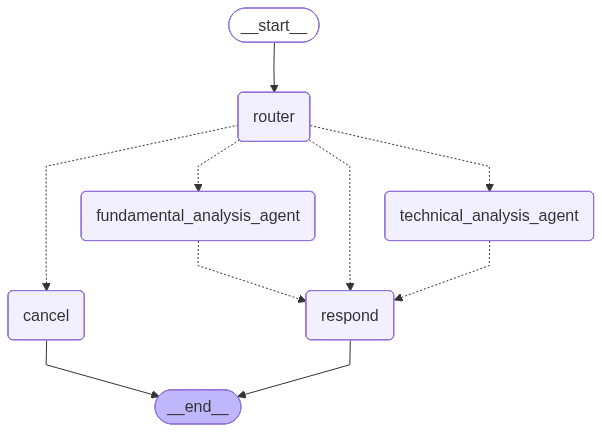

In [29]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

Invoke!

In [17]:
config = {
    "configurable": {"thread_id": "thread_9921"}
}

for chunk in agent.stream(
    {
        "messages": [HumanMessage(content=query)]
    },
    config = config
):
    for update in chunk.values():
        if update:
            if isinstance(update, tuple):
                print(chunk)
            else:
                for message in update.get('messages', []):
                    message.pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__interrupt__': (Interrupt(value={'question': 'Approve execution?', 'details': [Step(step_number=1, action=UseAgent(agent_to_use='fundamental_analysis_agent', query_to_send='Using the past 12 months of Apple Inc. (AAPL) financial data and market factors, perform a fundamental analysis. Review revenue growth, profitability margins, cash flow, balance sheet strength, debt levels, capital allocation, product/service mix, competitive position, macro risks. Assess intrinsic value and provide a valuation takeaway (undervalued/overvalued) with key drivers and risks.')), Step(step_number=2, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Using the past 12 months of Apple Inc. (AAPL) price data, perform a technical analysis. Evaluate trend, moving averages (50-day and 200-day), RSI, MACD, volatility, support/resistance, and chart patterns. Provide buy/hold/sell signals with rationale.')), Step(step_number=3, action=UseAgent(agent_to_use='fundamental_analysis_agent', qu

#### Happy path

In [18]:
for chunk in agent.stream(
    Command(resume="This looks good. Proceed."),
    config=config
):
    for update in chunk.values():
        if update:
            if isinstance(update, tuple):
                print(chunk)
            else:
                for message in update.get('messages', []):
                    message.pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Plan approved. Proceeding to execution.
INFO:__main__:query: Analyze Apple Inc. (AAPL) price action over the past year using stock market data: trend, moving averages (e.g., 50-day and 200-day), RSI, MACD, volatility, support and resistance levels, notable chart patterns, and recent volume. Provide signals and caveats.
INFO:__main__:query: Analyze Tesla, Inc. (TSLA) price action over the past year using stock market data: trend, moving averages (e.g., 50-day and 200-day), RSI, MACD, volatility, support and resistance levels, notable chart patterns, and recent volume. Provide signals and caveats.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

It looks like your message came through empty. How can I help? Here are a few options:

- Evaluate fundamentals for a stock: I can run a fundamental analysis (profitability, liquidity, solvency, valuation) for a ticker you specify.
- Compare multiple tickers: I can assess several stocks in parallel to spot potentially undervalued names.
- Explain ratios: I can break down what Gross Margin, ROE, Quick Ratio, P/E, etc. mean and how to interpret them.
- Build a watchlist: I can suggest stocks that meet certain criteria (e.g., strong margins, solid balance sheets, reasonable valuations).
- Other finance topics: portfolio risk, asset allocation, or how to screen for undervalued stocks.

Please provide:
- The stock ticker(s)
- Optional: the period for evaluation (1mo, 3mo, 6mo, 1y, etc.) or leave as default
- Any preferences or constraints (industry, market cap, region)

If you’d like, I can also run a parallel

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/Users/tituslim/Documents/2. Personal Learning Folder/Personal Projects/glowing-guide/notebooks/../tools/fundamental_analysis_tools.py:44: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  self.data = self.data[self.data.index.isin(self.dates)]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/Users/tituslim/Documents/2. Personal Learning Folder/Personal Projects/glowing-guide/notebooks/../tools/fundamental_analysis_tools.py:44: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before 

================================== Ai Message ==================================

Here’s a structured read of AAPL (past year, 1y) based on the technical indicators available from the analysis run you requested. Note: some items you asked for (explicit RSI value, exact 50- and 200-day moving averages, precise support/resistance levels, chart patterns, and recent volume) weren’t returned in the tool outputs. I’ve included the available signals and caveats, plus what they imply. I can fetch precise numbers for the missing items if you want.

What the indicators are saying (past year)

- Trend signals (mixed/unclear overall)
  - Accumulation/Distribution Index (ADI): buy signal. Suggests some net buying pressure/accumulation over the period.
  - Aroon: wait. No clear trend initiation or reversal signal from this metric.
  - Ichimoku: sell. Price is below the cloud, which points to bearish bias in the trend over the period.
  - MACD: sell. Negative momentum; the MACD line is below the MACD

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here’s a concise, data-grounded view of Apple Inc. (AAPL) over the past year based on the fundamentals snapshot you provided (fiscal year ending 2025-09-30). I’ll call out what the numbers imply, plus red flags and what to monitor next. Note: certain valuation figures look unusual in the data you supplied (e.g., P/S and P/B), and several key items (revenue, cash flow, guidance) aren’t included in the snapshot. I’ve flagged those data gaps where relevant.

Data snapshot (period: trailing year to 2025-09-30)
- Gross margin: 46.9%
- Net margin: 26.9%
- Current ratio: 0.893
- Return on assets (ROA): 31.2%
- Return on equity (ROE): 151.9%
- Debt to assets: 0.795
- Debt to equity: 3.872
- P/E ratio: 33.96
- P/B ratio: 0.13
- P/S ratio: 0.13
- The data also shows a margin improvement vs the prior year (gross margin up from ~44.2% to ~46.9%; net margin up from ~25.3% to ~26.9%).

What these numbers imply (interpr

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here’s a concise, practical take on TSLA’s price action over roughly the past year, using the latest technical snapshot you asked for. Note: the tool provides qualitative signals rather than precise numeric values. I’ve combined that with standard chart-reading guidance to give you signals and caveats you can act on.

What the tool shows (1-year window)
- Trend indicators
  - Accumulation/Distribution Index (ADI): wait for a clear trend change.
  - Aroon: no decisive new trend signal.
  - Ichimoku: price trend described as “in transition.”
  - Takeaway: no strong, sustained up or down trend is asserted by these indicators; market appears to be oscillating with no persistent directional breakout.

- Momentum and volatility signals
  - MACD: sell signal (MACD line below the MACD signal line), indicating bearish momentum.
  - Stochastic Oscillator (stoch): buy signal (stochastic momentum suggests upside pote

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here’s a concise fundamentals-focused take on Tesla, Inc. (TSLA) for the past year, using the available metrics from the tool you asked for. Note: the data provided by the analytics tool covers margins, liquidity, leverage, and returns, but not direct revenue growth, cash flow (CFO/FCF), or explicit guidance. I’ve noted where data is missing or ambiguous.

What the data shows (period: last 1 year, with year-end snapshots)
- Profitability
  - Gross margin: 2022 = 25.60%, 2023 = 18.25%, 2024 = 17.86%
    - Trend: substantial margin compression over the last year-to-year period, continuing a multi-year downtrend from 2022 highs.
  - Net margin: 2022 = 15.45%, 2023 = 15.50%, 2024 = 7.30%
    - Trend: net profitability weakened meaningfully in 2024 after solid double-digit margins in 2022–2023.
- Returns
  - ROA (Net Income / Total Assets): 2022 = 15.28%, 2023 = 14.07%, 2024 = 5.84%
  - ROE (Net Income / Share

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I can give a clear buy/hold/sell view, but I don’t have your exact latest 1-year data in front of me. If you’d like, I can pull the latest 1-year fundamentals and price data for AAPL and TSLA and give you a precise, data-driven call with rationale. In the meantime, here’s a concise, non-personalized read based on typical 1-year dynamics for these two names:

Apple (AAPL)
- Recommendation: Hold
- Why: Apple benefits from a strong moat, robust profitability, and huge cash flow, with continued growth in Services and ecosystem advantages. Valuation is generally premium, which means more upside risk is tied to continued growth execution and services expansion rather than multiple expansion alone. Near-term risks include regulatory scrutiny (App Store economics), potential macro softness in discretionary hardware demand, and supply-chain/comps concerns.
- If you already own it: consider quality-diving on meanin

In [17]:
for chunk in agent.stream(
    Command(resume="Don't proceed. Remove all the fundamental analysis steps. These tickers are bluechip tickers so their fundamentals are already very strong."),
    config=config
):
    for update in chunk.values():
        if update:
            if isinstance(update, tuple):
                print(chunk)
            else:
                for message in update.get('messages', []):
                    message.pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__interrupt__': (Interrupt(value={'question': 'Approve execution?', 'details': [Step(step_number=1, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Provide a technical analysis of Apple Inc. (AAPL) over the past 12 months, including price trend, 50-day and 200-day moving averages, RSI, MACD, support/resistance levels, volume patterns, chart patterns, and recent momentum signals.')), Step(step_number=2, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Provide a technical analysis of Tesla, Inc. (TSLA) over the past 12 months, including price trend, 50-day and 200-day moving averages, RSI, MACD, support/resistance levels, volume patterns, chart patterns, and recent momentum signals.')), Step(step_number=3, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send="Synthesize the two stocks' technical analyses and provide a concise buy/hold/sell recommendation for Apple (AAPL) and Tesla (TSLA) based solely on technical data fro

Path with feedback

In [30]:
config = {
    "configurable": {"thread_id": "thread_9139"}
}

for chunk in agent.stream(
    {
        "messages": [HumanMessage(content=query)]
    },
    config = config
):
    for update in chunk.values():
        if update:
            if isinstance(update, tuple):
                print(chunk)
            else:
                for message in update.get('messages', []):
                    message.pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__interrupt__': (Interrupt(value={'question': 'Approve execution?', 'details': [Step(step_number=1, action=UseAgent(agent_to_use='fundamental_analysis_agent', query_to_send='Analyze Apple (AAPL) fundamentals over the past year: summarize revenue growth, earnings, margins, cash flow, balance sheet strength (debt vs liquidity), capital allocation, product cycle impact, competitive landscape, risks, and management commentary; provide implications for stock valuation.')), Step(step_number=2, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Analyze Apple (AAPL) technicals using the past 12 months of price data: report trend indicators (50-day and 200-day moving averages), MACD, RSI, momentum, volume patterns, and identify support/resistance levels and notable chart patterns.')), Step(step_number=3, action=UseAgent(agent_to_use='fundamental_analysis_agent', query_to_send='Analyze Tesla (TSLA) fundamentals over the past year: summarize revenue growth, earnings, margin

In [31]:
for chunk in agent.stream(
    Command(resume="Not approved. Please remove all fundamental analysis steps."),
    config=config
):
    for update in chunk.values():
        if update:
            if isinstance(update, tuple):
                print(chunk)
            else:
                for message in update.get('messages', []):
                    message.pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:User feedback: Not approved. Please remove all fundamental analysis steps.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'__interrupt__': (Interrupt(value={'question': 'Approve execution?', 'details': [Step(step_number=1, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send="For Apple (AAPL), analyze the stock's price action over the past 12 months using technical indicators. Include 50-day and 200-day moving averages, RSI, MACD, volume patterns, trend strength, and key support/resistance levels. Highlight near-term timing signals and any notable chart patterns.")), Step(step_number=2, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send="For Tesla (TSLA), analyze the stock's price action over the past 12 months using technical indicators. Include 50-day and 200-day moving averages, RSI, MACD, volume patterns, trend strength, and key support/resistance levels. Highlight near-term timing signals and any notable chart patterns.")), Step(step_number=3, action=UseAgent(agent_to_use='technical_analysis_agent', query_to_send='Synthesize the findings from steps 1 and 2 and p

In [32]:
for chunk in agent.stream(
    Command(resume="This looks good. Proceed."),
    config=config
):
    for update in chunk.values():
        if update:
            if isinstance(update, tuple):
                print(chunk)
            else:
                for message in update.get('messages', []):
                    message.pretty_print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:User feedback: Not approved. Please remove all fundamental analysis steps.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:User feedback: This looks good. Proceed.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Plan approved. Proceeding to execution.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:query: Provide a technical analysis of Tesla, Inc. (TSLA) using the past 12 months of price data. Include trend assessment, moving averages (50-day and 200-day), RSI, MACD signals, support/resistance levels, volume patterns, and a concise technical outlook with a buy/hold/sell cue.
INFO:__main__:query: Provide a technical analysis 

================================== Ai Message ==================================

Here are concise final recommendations based on the mixed signals from steps 1 and 2.

Apple (AAPL)
- Recommendation: Hold
- Why: Signals are largely neutral with no clear trend or momentum confirmation. The only active signal is a Stochastic Sell, while ADI, MACD, RSI, MA relations, and volume don’t show a decisive move. Price/volume pattern suggests a range-bound setup rather than a breakout.

Tesla (TSLA)
- Recommendation: Hold
- Why: Mixed signals: ADI indicates accumulation (bullish potential), but Stochastic Sell suggests near-term downside pressure. Other indicators (MA/RSSI/MACD) are neutral. No clear breakout above resistance or breakdown below support, so wait for a confirmatory move (e.g., bullish MACD cross or a sustained volume-based breakout) before acting.

If you’d like, I can re-run with a different period or pull in explicit support/resistance levels and moving-average crossovers to refi

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here is a concise, data-grounded technical view of Tesla, Inc. (TSLA) using about the last 12 months of price data. Note: the available indicator outputs from the current analysis tool are more qualitative than numeric in this session, so I’ve integrated those signals with standard chart-reading interpretation and flagged data gaps where exact levels aren’t provided.

What the indicators say (qualitative signals)
- Trend assessment
  - Ichimoku indicates the price trend is in transition (unclear, not a confirmed up or down trend).
  - Aroon suggests no definitive new trend formation; the signal is effectively neutral.
  - Accumulation/Distribution (ADI) and Bollinger Bands in this run show “wait” or neutral indicators, i.e., no strong trend confirmation.
  - Overall: trend is mixed/transitioning rather than clearly bullish or bearish over the past year.

- Moving averages (50-day and 200-day)
  - Specific

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Apple (AAPL)
- Recommendation: Hold
- Rationale (price-data only): Over the past year the price has been mostly range-bound with no clear breakout. MACD shows downward momentum, and price sits below the Ichimoku cloud (bearish bias). There are some near-term oversold/stochastic hints, but nothing confirms a sustained up move. Best to wait for a clear breakout or a decisive reversal confirmed by volume.

Tesla (TSLA)
- Recommendation: Hold
- Rationale (price-data only): The year shows a transition/neutral trend rather than a clear up or down trend. MACD indicates some bearish momentum, while stochastic signals show near-term upside pressure. No strong breakout above resistance or breakdown below support to justify new positioning. Hold and watch for a confirmatory move with volume.

If you’d like, I can pull precise numeric levels (recent swing highs/lows, approximate support/resistance, and momentum indic